In [1]:
import pandas as pd
#import category_encoders as ce
import numpy as np
import matplotlib
import os
import snowflake.connector
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pprint#Allows us to neatly display text

%matplotlib inline

/Users/kanghuang/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Pull data from SalesForce

In [ ]:
ctx = snowflake.connector.connect(
    user='kang.huang3@wework.com',
    account='ai42698.us-east-1',
    authenticator='externalbrowser'
    )
cur = ctx.cursor()
query_str = "show columns in CENTRAL.CDM_FEATURE_STORE.ACCOUNT_LOCATION_MONTHLY"
cur.execute(query_str)
res = cur.fetchall()
metadata = pd.DataFrame(res)
columns = metadata[2].tolist()
query_str = "select %s from CENTRAL.CDM_FEATURE_STORE.ACCOUNT_LOCATION_MONTHLY where month >= '2019-10-01'"
query_str = query_str % (','.join(columns))
cur.execute(query_str)
res = cur.fetchall()
df = pd.DataFrame(res, columns=columns)
df.to_csv('account_location_monthly.csv')

### Dataset construction
1. The date of raw data range from 2019-01-01 to 2020-10-01.  
2. The index of dataset is account, location, and month. 
3. The churn label will be dependent on room occupancy (OCCUPANCY - OCCUPANCY_DD - OCCUPANCY_HD). For example, if current month is N, the room occupancy of any month from N+1 to N+4 is 0, the churn label will be 1 otherwise 0. 
4. DESK_LOSS_LAST_3_MONTHS related columns will be suspicious to be cheating features, after checking DESK_LOSS_LAST_3_MONTHS == room occupancy, only 0.2% rows' label has label leakage issue.
5. Some accounts may churn for 1 month and then come back, those cases only account for 0.002%.

In [2]:
start_year = 2019
def date2month(row):
    year, month = row['MONTH'].split('-')[:2]
    year = int(year)
    month = int(month)
    total_month = (year-start_year)*12 + month
    return total_month

def churn_label(df, month_n):
    df = df.sort_values('MONTH').reset_index(drop=False)
    occupancy = df['OCCUPANCY'].tolist()
    occupancy_dd = df['OCCUPANCY_DD'].tolist()
    occupancy_hd = df['OCCUPANCY_HD'].tolist()
    months = df['MONTH'].tolist()
    
    # get room occupancy
    for i in range(len(occupancy)):
        
        occupancy[i] -= (occupancy_dd[i]+occupancy_hd[i])
        assert occupancy[i] >= 0

    min_month = min(months)
    max_month = max(months)
    # prevent any month gap
    assert min_month+len(occupancy)-1 == max_month 
    churn = []
    month = []
    early = []
    for i in range(len(occupancy)-month_n):  
        if occupancy[i] <= 0:
            continue
        month.append(months[i])
        # if the room occupancy of any month from N+1 to N+4 is 0, consider as a churn event.
        for j in range(1, month_n+1):
            if occupancy[i+j] == 0:
                churn.append(1)
                early.append(j)
                break
        if len(churn) < len(month):
            churn.append(0)
            early.append(0)
    return pd.DataFrame(list(zip(map(lambda m: '%d-%02d-01'%(start_year+(m-1)//12, (m-1)%12+1),month), churn, early)), columns=['MONTH', 'churn', 'early'])
    


In [33]:
churn_path = 'account_location_monthly.csv'
if os.path.exists(churn_path):
    print ('churn dataset found ...')
    churn_df = pd.read_csv(churn_path)
    churn_df = churn_df.drop(columns=['Unnamed: 0'])
else:
    print ('churn dataset not found, creating ...')
    df = pd.read_csv('account_location_monthly.csv')
    gt_df = df[['MONTH', 'SALES_ACCOUNT_UUID', 'LOCATION_UUID', 'OCCUPANCY', 'OCCUPANCY_DD', 'OCCUPANCY_HD']]
    gt_df['MONTH'] = gt_df.apply(date2month, axis=1)
    label_df = gt_df.groupby(['SALES_ACCOUNT_UUID', 'LOCATION_UUID']).apply(lambda df: churn_label(df, 4)).reset_index(drop=False)
    label_df = label_df.reset_index(drop=False)
    churn_df = pd.merge(df, label_df[['SALES_ACCOUNT_UUID', 'LOCATION_UUID', 'MONTH', 'early', 'churn']], on=['SALES_ACCOUNT_UUID', 'LOCATION_UUID', 'MONTH'])
    churn_df = churn_df.sort_values(['SALES_ACCOUNT_UUID', 'LOCATION_UUID', 'MONTH'])
    churn_df = churn_df.drop(columns=['Unnamed: 0'])
    churn_df.to_csv(churn_path)
churn_df = churn_df[~((churn_df['churn'] == 1) & (churn_df['DESK_LOSS_LAST_3_MONTHS']*-1 == churn_df['OCCUPANCY']))] 


churn dataset found ...


### Feature construction
1. features consist of continuous and categorical features.
2. continuous features are inferred from discrete, exclude and label set.
3. columns with a single value will be removed.  
3. categorical features are encoded one-hot vector.
4. continuous features apply mean & standard deviation normalization.
5. the date of train data will be ranged from 2020 Jan to 2020 April (4 months). 
6. the date of test data will be ranged from 2020 May to 2020 June (2 months).

In [44]:
FEATURE_COLUMNS = {
    'discrete': ['SALES_MARKET', 'TERRITORY', 'IS_PRE_MOVE_IN', 'IS_ENTERPRISE_500', 'SECTOR', 'ROE_SEGMENT', 'IS_NONPROFIT',
                'HQ_MARKET', 'HQ_TERRITORY', 'HQ_REGION'], 
    'label': 'churn',
    'exclude': ['early', 'SALES_ACCOUNT_UUID', 'LOCATION_UUID', 'MONTH', 'FIRST_MOVE_IN_MONTH', 'ORGANIZATION_UUID',
                'REGION', 'COUNTRY_CODE', 'FIRST_CONTRACT_SIGN_DATE', 'FIRST_MOVE_IN_MONTH', 'Unnamed: 0', 'Unnamed: 0.1']
}
if not 'continuous' in FEATURE_COLUMNS:
    no_cont_cols = []
    FEATURE_COLUMNS['continuous'] = []
    for feat_list in FEATURE_COLUMNS.values():
        if not isinstance(feat_list, list):
            feat_list = [feat_list]
        no_cont_cols.extend(feat_list)
    for col in churn_df.columns:
        if not col in no_cont_cols:
            FEATURE_COLUMNS['continuous'].append(col)
            
class Feature:
    def __init__(self, df):
        self.df = df 
        self.mean = []
        self.std = []
        self.max = []
        self.min = []
        self.cons_feat = self.constant(df)
                     
    def __fit_continuous(self):
        df = self.df
        cont_col = self.cont_col = [col for col in df if (col in FEATURE_COLUMNS['continuous']) and (not col in self.cons_feat)]
        print (len(cont_col))
        for col in cont_col:
            col_feat = df.loc[df[col].notna(), col]
            self.mean.append(col_feat.mean())
            self.std.append(col_feat.std())
        self.mean = np.expand_dims(self.mean, axis=0)
        self.std = np.expand_dims(self.std, axis=0)
    
    def __fit_discrete(self):
        df = self.df
        disc_col = self.disc_col = [col for col in df.columns if (col in FEATURE_COLUMNS['discrete']) and (not col in self.cons_feat)]
        print (len(disc_col))
        df[disc_col] = df[disc_col].astype(str)
        disc_dats = []
        self.col_val = {}
        for col in disc_col:
            dat = pd.get_dummies(df[col], prefix=col, dummy_na=False)  # it has nan itself
            disc_dats.append(dat)
            self.col_val[col] = df.loc[~df.duplicated(col), col]
        disc_dats = pd.concat(disc_dats, axis=1)
        self.disc_col_order = disc_dats.columns.to_list()

    def __transform_continuous(self, df):
        cont_col = self.cont_col
        df = df[cont_col]
        df = df.fillna(value=0).astype(float)
        np_dat = df.loc[:,cont_col].to_numpy()
        np_dat = (np_dat - self.mean) / self.std
        return np_dat
    
    def __transform_discrete(self, df):
        disc_col = self.disc_col
        df[disc_col] = df[disc_col].astype(str)
        disc_dats = []
        for col in disc_col:
            row = self.col_val[col]
            disc_dat = pd.get_dummies(pd.concat([row, df[col]], axis=0), prefix=col, dummy_na=False)  # it has nan itself
            disc_dats.append(disc_dat.iloc[len(row):])
    
        disc_dats = pd.concat(disc_dats, axis=1)
        np_dat = disc_dats[self.disc_col_order].to_numpy()
        return np_dat
    

    def fit(self):
        print ('fitting continous ...')
        self.__fit_continuous()
        print ('fitting discrete ...')
        self.__fit_discrete()
        
    def column_names(self):
        return self.cont_col + self.disc_col_order

    
    def transform(self, df, dformat='numpy'):
        np_dats = []
        np_dats.append(self.__transform_continuous(df))
        np_dats.append(self.__transform_discrete(df))
        data = np.hstack(np_dats) 
        if dformat == 'numpy':
            return data
        elif dformat == 'pandas':
            return pd.DataFrame(data, columns=self.column_names())
        
    def fit_transform(self, dformat='numpy'):
        self.fit()
        return self.transform(self.df, dformat)
   
    def constant(self, df):
        cons_feat = []
        for col in df:
            if df[col].nunique() == 1:
                cons_feat.append(col)
        return cons_feat

        
train_df = churn_df[churn_df['MONTH'] < '2020-05-01']
test_df = churn_df[churn_df['MONTH'] >= '2020-05-01']

feature = Feature(train_df)
print ('creating train features ...')
X_train = feature.fit_transform('pandas')
y_train = train_df[FEATURE_COLUMNS['label']].to_numpy().astype('int')
print ('creating test features ...')
X_test = feature.transform(test_df, 'pandas')
y_test = test_df[FEATURE_COLUMNS['label']].to_numpy().astype('int')

creating train features ...
fitting continous ...
182
fitting discrete ...
10


/Users/kanghuang/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


creating test features ...


### Model construction
Extreme gradient boosting is a popular approach for building a good baseline model or even production model on column features. The parameters are not perfectly tuned but set according to industry guidance:
1. max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
2. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups
3. subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
4. scale_pos_weight=: Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).

In [45]:
clf = xgb.XGBClassifier(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=5,
    scale_pos_weight=len(y_train[y_train==0])/ len(y_train[y_train==1]),
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    learning_rate=0.1,    
    verbosity=0,
    booster='gbtree',
)
clf.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.415891362101631,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=0)

Text(0, 0.5, 'Feature Importance Score')

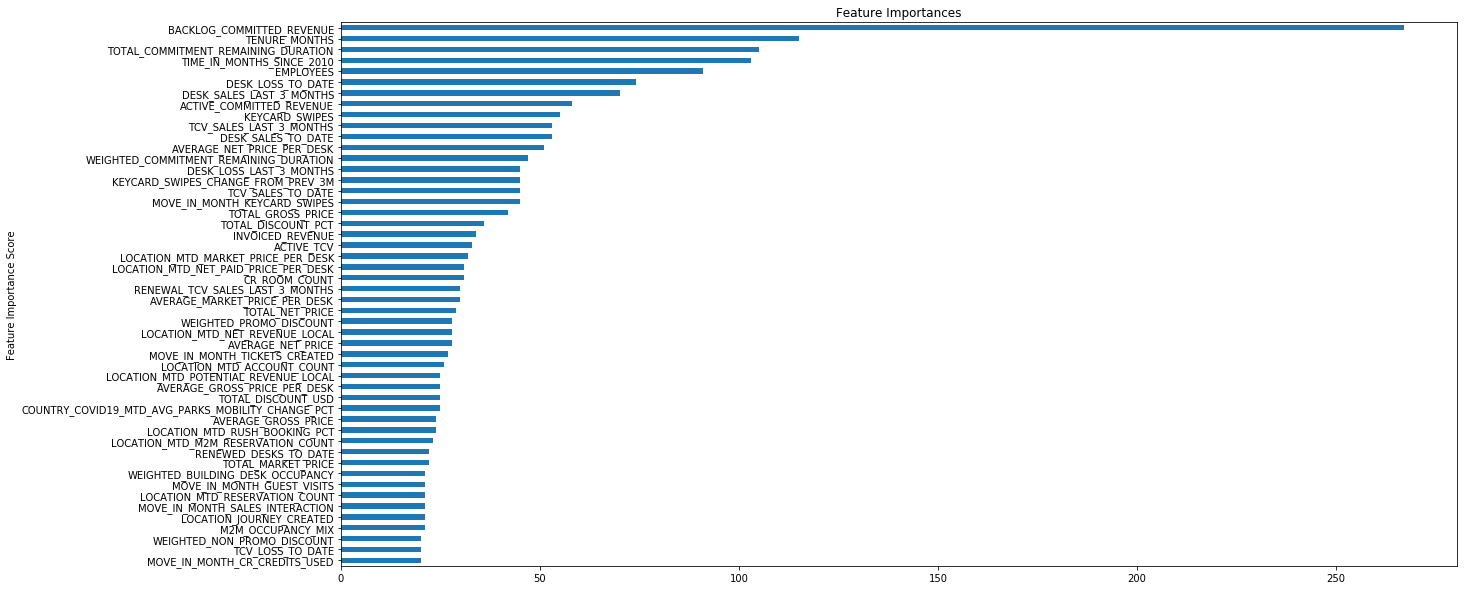

In [46]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)[:50][::-1]
feat_imp.plot(kind='barh', title='Feature Importances', figsize=(20, 10))
plt.ylabel('Feature Importance Score')


In [47]:
def evaluate(X, y, thresh=.5):
    y_prob = clf.predict_proba(X)
    y_pred = y_prob[:,1]
    print('auc score:', roc_auc_score(y, y_pred))
    y_pred[y_pred > thresh] = 1
    y_pred[y_pred <= thresh] = 0
    print('f1 score:', f1_score(y, y_pred))
    print('recall:', recall_score(y, y_pred))
    print('precision:', precision_score(y, y_pred))
    disp = plot_confusion_matrix(clf, X, y,
                             display_labels=['stay','churn'],
                             cmap=plt.cm.Blues,
                             normalize='true')

auc score: 0.8010201101576665
f1 score: 0.4486430354858347
recall: 0.7293684310799226
precision: 0.323956110082082


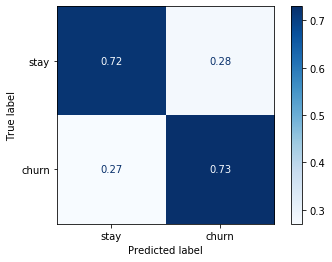

In [48]:
evaluate(X_train, y_train)

auc score: 0.8023772061690988
f1 score: 0.500745297527505
recall: 0.8405751052506156
precision: 0.3565844453430381


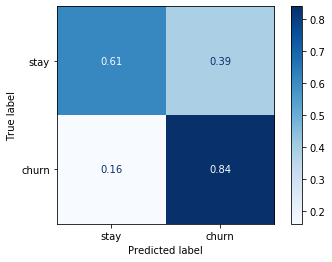

In [49]:
evaluate(X_test, y_test, 0.5)

auc score: 0.8100939699308563
f1 score: 0.2566947207345065
recall: 0.15990150131066805
precision: 0.6504038772213248


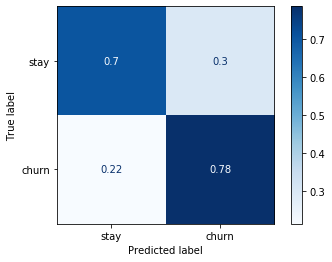

In [43]:
evaluate(X_test, y_test, 0.8)